In [41]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display

<span style="font-size:30px; font-family:'Times new roman'; font-weight:bold">
Import Data🎒
</span>

In [42]:
df = pd.read_csv("../data/modelTable.csv")

In [43]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTM_PAYMENT_DIFF_MIN,INSTM_PAYMENT_DIFF_MAX,INSTM_PAYMENT_RATIO_MEAN,INSTM_PAYMENT_RATIO_STD,INSTM_IS_LATE_SUM,INSTM_IS_EARLY_SUM,INSTM_IS_OVERPAY_SUM,INSTM_IS_UNDERPAY_SUM,INSTM_IS_MISSED_SUM,INSTM_NUM_INSTALMENT_NUMBER_COUNT
0,100002,1,Cash loans,M,0,1,0,202500.0,406597.5,24700.5,...,0.000,0.0,1.000000,0.000000,0.0,19.0,0.0,0.0,0.0,19.0
1,100003,0,Cash loans,F,0,0,0,270000.0,1293502.5,35698.5,...,0.000,0.0,1.000000,0.000000,0.0,25.0,0.0,0.0,0.0,25.0
2,100004,0,Revolving loans,M,1,1,0,67500.0,135000.0,6750.0,...,0.000,0.0,1.000000,0.000000,0.0,3.0,0.0,0.0,0.0,3.0
3,100006,0,Cash loans,F,0,1,0,135000.0,312682.5,29686.5,...,0.000,0.0,1.000000,0.000000,0.0,16.0,0.0,0.0,0.0,16.0
4,100007,0,Cash loans,M,0,1,0,121500.0,513000.0,21865.5,...,-22655.655,0.0,0.954545,0.209751,16.0,41.0,0.0,4.0,0.0,66.0


In [44]:
# identify and remove highly correlated features
# select numeric features without target
num = df.select_dtypes(include=np.number).columns.drop('TARGET')
corrMatrix = df[num].corr().abs()

# compute all high corr
highCorr = []
for i in range(len(corrMatrix.columns)):
    for j in range(i+1, len(corrMatrix.columns)):
        val = corrMatrix.iloc[i, j]
        if val > 0.85:
            f1 = corrMatrix.index[i]
            f2 = corrMatrix.columns[j]
            highCorr.append((f1, f2, val))

for f1, f2, val in highCorr:
    print(f"  {f1} | {f2} = {val:.2f}")

  CNT_CHILDREN | CNT_FAM_MEMBERS = 0.88
  AMT_CREDIT | AMT_GOODS_PRICE = 0.99
  FLAG_PHONE | HAS_CONTACT_INFO = 0.91
  REG_REGION_NOT_WORK_REGION | LIVE_REGION_NOT_WORK_REGION = 0.86
  OBS_30_CNT_SOCIAL_CIRCLE | OBS_60_CNT_SOCIAL_CIRCLE = 1.00
  DEF_30_CNT_SOCIAL_CIRCLE | DEF_60_CNT_SOCIAL_CIRCLE = 0.86
  BUREAU_SK_ID_BUREAU_COUNT | BUREAU_IS_CLOSED_SUM = 0.92
  BUREAU_SK_ID_BUREAU_COUNT | BUREAU_IS_CONSUMER_SUM = 0.93
  BUREAU_IS_CLOSED_SUM | BUREAU_IS_CONSUMER_SUM = 0.92
  BUREAU_BB_MONTHS_BALANCE_COUNT_SUM | BUREAU_BB_IS_CLOSED_SUM_SUM = 0.91
  BUREAU_BB_IS_DPD_30_SUM_SUM | BUREAU_BB_IS_DPD_60_SUM_SUM = 0.99
  BUREAU_BB_IS_DPD_30_SUM_SUM | BUREAU_BB_IS_DPD_120_SUM_SUM = 0.97
  BUREAU_BB_IS_DPD_60_SUM_SUM | BUREAU_BB_IS_DPD_120_SUM_SUM = 0.99
  INSTM_PAYMENT_RATIO_MEAN | INSTM_PAYMENT_RATIO_STD = 0.94
  INSTM_IS_LATE_SUM | INSTM_IS_UNDERPAY_SUM = 0.89
  INSTM_IS_EARLY_SUM | INSTM_NUM_INSTALMENT_NUMBER_COUNT = 0.89


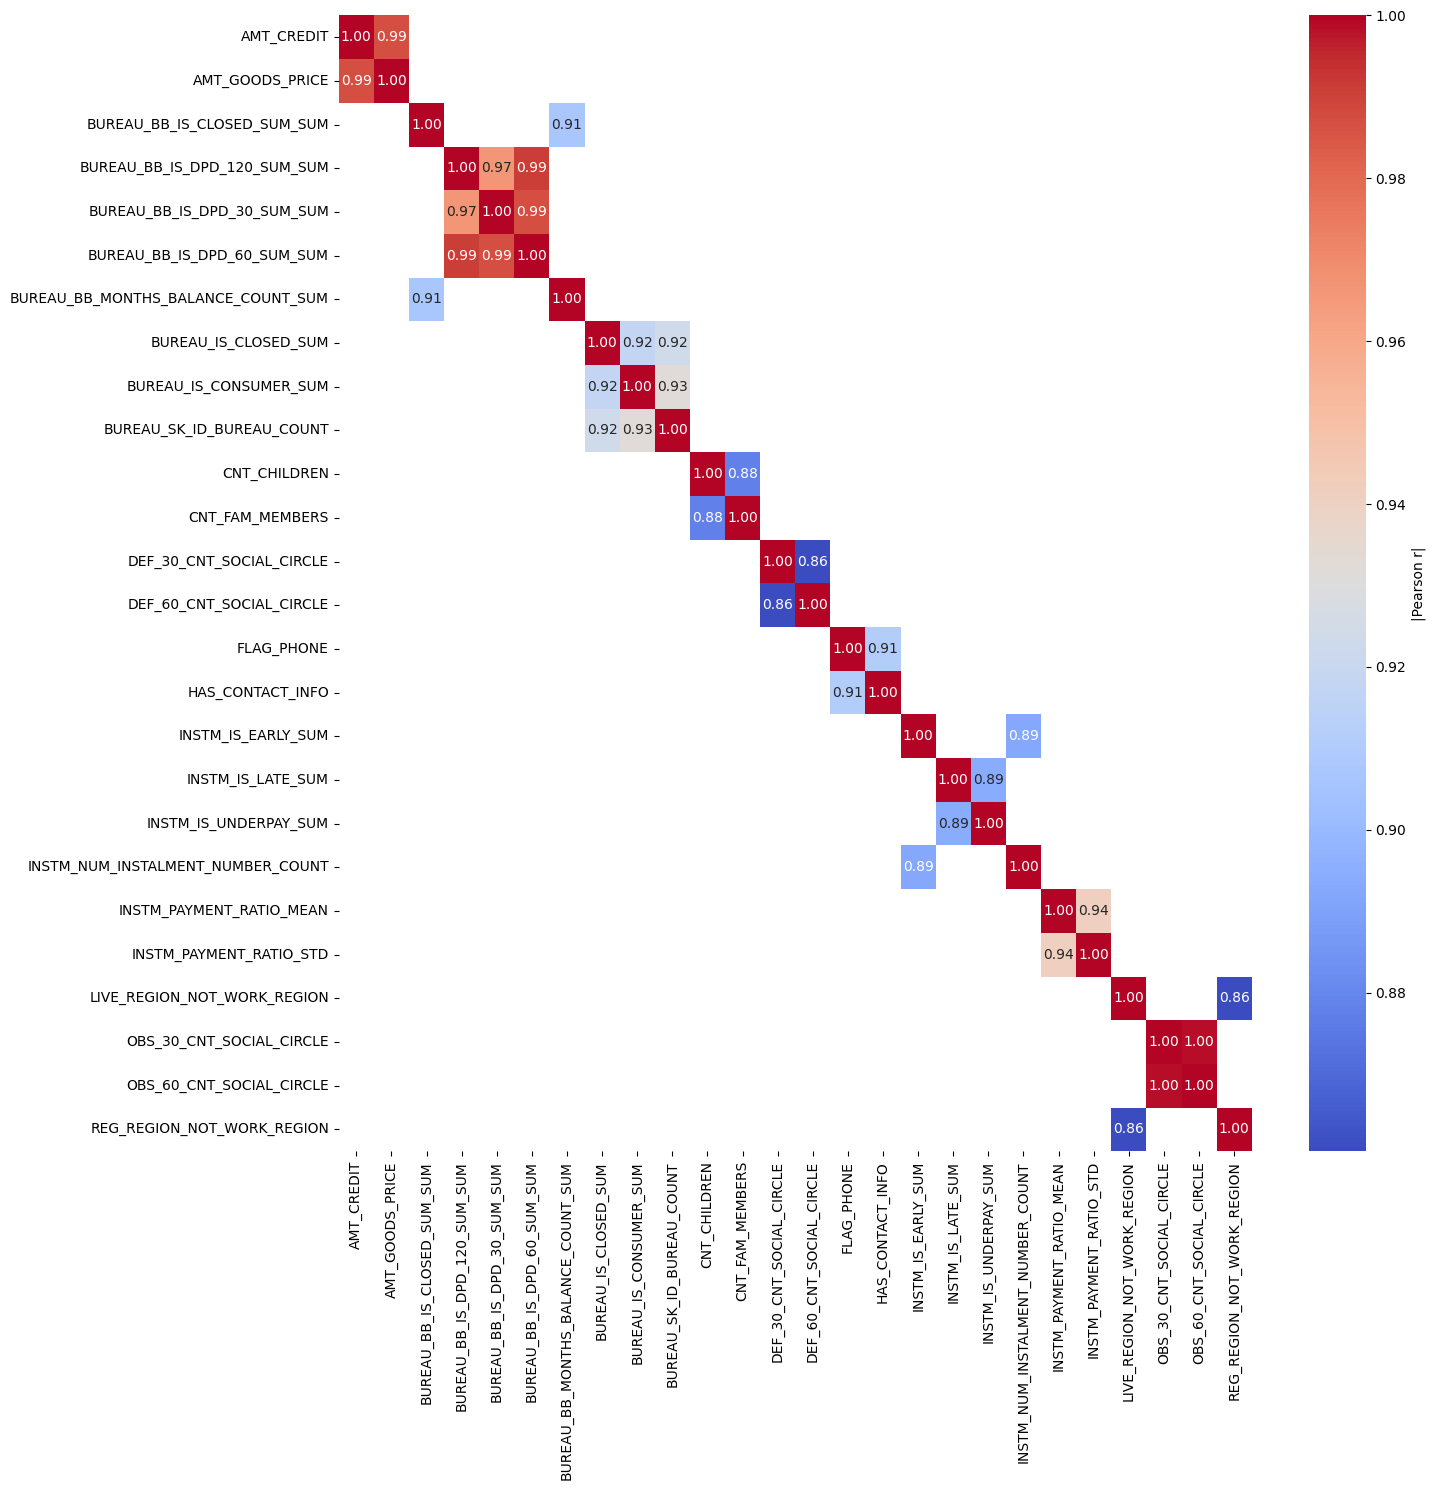

In [45]:
highFeatures = sorted({f for pair in highCorr for f in pair[:2]})
corr = corrMatrix.loc[highFeatures, highFeatures]
mask = corr < 0.85

# plot with seaborn
plt.figure(figsize=(len(highFeatures)*0.5+2, len(highFeatures)*0.5+2))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar_kws={'label': '|Pearson r|'}
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
# i gonna drop 
dropfeatures = ['AMT_GOODS_PRICE', 
                'CNT_CHILDREN', 
                'FLAG_PHONE', 
                'REG_REGION_NOT_WORK_REGION',
                'OBS_60_CNT_SOCIAL_CIRCLE',
                'DEF_60_CNT_SOCIAL_CIRCLE',
                'BUREAU_SK_ID_BUREAU_COUNT',
                'BUREAU_BB_IS_CLOSED_SUM_SUM',
                'BUREAU_BB_IS_DPD_60_SUM_SUM',
                'INSTM_PAYMENT_RATIO_MEAN', 
                'INSTM_IS_UNDERPAY_SUM', 
                'INSTM_NUM_INSTALMENT_NUMBER_COUNT']

In [47]:
dfDropCorr = df.drop(columns=list(dropfeatures))

In [48]:
dfDropCorr.shape

(307511, 86)

<span style="font-size:30px; font-family:'Times new roman'; font-weight:bold">
Encodeing 🧮
</span>

In [49]:
catCol = df.select_dtypes(include=['object','category']).columns

# Decide encoding
encodingSol = {}
for col in catCol:
    n_levels = df[col].nunique()
    if n_levels == 2:
        # Binary --> 0/1
        encodingSol[col] = 'Binary'
    elif n_levels <= 10:
        # Small cardinality --> One-Hot (drop one to avoid collinearity)
        encodingSol[col] = 'One-Hot Encoding'
    else:
        # High cardinality → Target (mean) encoding with smoothing
        encodingSol[col] = 'Target (Mean) Encoding'

for col, method in encodingSol.items():
    print(f"{col:20s} → {method}")

NAME_CONTRACT_TYPE   → Binary
CODE_GENDER          → Binary
NAME_TYPE_SUITE      → One-Hot Encoding
NAME_INCOME_TYPE     → One-Hot Encoding
NAME_EDUCATION_TYPE  → One-Hot Encoding
NAME_FAMILY_STATUS   → One-Hot Encoding
NAME_HOUSING_TYPE    → One-Hot Encoding
OCCUPATION_TYPE      → Target (Mean) Encoding
WEEKDAY_APPR_PROCESS_START → One-Hot Encoding
ORGANIZATION_TYPE    → Target (Mean) Encoding


In [50]:
from sklearn.preprocessing import LabelEncoder

In [51]:
binary = [
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
]

onehot = [
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
]

target = [
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',
]

In [52]:
# binary
le = LabelEncoder()
for i in binary:
    dfDropCorr[i] = le.fit_transform(dfDropCorr[i].astype(str))

In [53]:
# onehot
dfDropCorr = pd.get_dummies(dfDropCorr,
                    columns=onehot,
                    drop_first=True)

In [56]:
# target mean
m = 100 # smoothing parameter
globalMean = dfDropCorr['TARGET'].mean()
for i in target:
    stats = dfDropCorr.groupby(i)['TARGET'].agg(['mean','count'])
    smooth = (
        stats['mean'] * stats['count'] 
        + globalMean * m
    ) / (stats['count'] + m)

    dfDropCorr[i] = dfDropCorr[i].map(smooth).fillna(globalMean)

In [57]:
dfDropCorr.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
0,100002,1,0,1,0,1,202500.0,406597.5,24700.5,0.018801,...,False,False,False,False,False,False,False,False,False,True
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,0.003541,...,False,False,False,False,True,False,False,False,False,False
2,100004,0,1,1,1,1,67500.0,135000.0,6750.0,0.010032,...,False,False,False,False,True,False,False,False,False,False
3,100006,0,0,0,0,1,135000.0,312682.5,29686.5,0.008019,...,False,False,False,False,False,False,False,False,False,True
4,100007,0,0,1,0,1,121500.0,513000.0,21865.5,0.028663,...,False,False,False,False,False,False,False,True,False,False


<span style="font-size:30px; font-family:'Times new roman'; font-weight:bold">
Save Data 💾
</span>

In [58]:
outputPath = "../data/toModel.csv"
dfDropCorr.to_csv(outputPath, index=False)
print(f"{outputPath}: ✅")

../data/toModel.csv: ✅
